In [51]:
#Import libraries
import pandas as pd
import numpy as np

#Read in data
law_df = pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/FirearmsAnalysis/main/main/nlp_law_df.csv")
print("Dimensions of Dataset: ",law_df.shape)
law_df.head(2)

Dimensions of Dataset:  (671, 18)


,Law ID,State,ST,Law Class,Effect,Type of Change,Effective Date,Year,Content,min_age,wait_days,Suicides,Homicides,Content_cleaned,len_text,sentiment,sentiment_label,sentiment_score
0,AL1005,Alabama,AL,castle doctrine,Permissive,Modify,2006-06-01,2006,A person who is justified under subsection (a)...,NaN,NaN,8.42,7.27,person justified subsection using physical for...,150,"{'label': 'LABEL_0', 'score': 0.5286481976509094}",LABEL_0,0.528648
1,AL1012,Alabama,AL,minimum age,Restrictive,Implement,2015-10-01,2015,"No person who is a minor, except under the cir...",18,NaN,10.34,8.43,person minor except circumstances provided sec...,116,"{'label': 'LABEL_0', 'score': 0.554276704788208}",LABEL_0,0.554277


In [52]:
#Clean up dataset
del law_df['sentiment'], law_df['sentiment_label']

law_df = law_df[law_df['Year']<2019]

In [53]:
#Identify laws that have been repealed
repealed_list = law_df.loc[law_df['Content'].str.contains("repealed", case=False)]
repealed_list = repealed_list[['Law ID']].reset_index()
del repealed_list['index']


#Remove laws that have been repealed from main df
keys = list(repealed_list.columns.values)
i1 = law_df.set_index(keys).index
i2 = repealed_list.set_index(keys).index
law_df2 = law_df[~i1.isin(i2)]

print("Old Dimensions: ",law_df.shape)
print("New Dimensions: ",law_df2.shape)

law_df = law_df2

Old Dimensions:  (639, 16)
New Dimensions:  (593, 16)


In [54]:
law_df_perm = law_df[law_df['Effect']=="Permissive"]
law_df_rest = law_df[law_df['Effect']=="Restrictive"]

print("Permissive laws in dataset: ",law_df_perm.shape[0])
print("Restrictive laws in dataset: ",law_df_rest.shape[0])

Permissive laws in dataset:  106
Restrictive laws in dataset:  487


In [55]:
law_df_perm['Law Class'].value_counts()

carrying a concealed weapon (ccw)    39
castle doctrine                      32
minimum age                           9
open carry                            8
background checks                     7
waiting period                        3
firearm sales restrictions            2
dealer license                        2
permit to purchase                    2
registration                          1
child access laws                     1
Name: Law Class, dtype: int64

In [56]:
law_df_rest['Law Class'].value_counts()

background checks             170
prohibited possessor          151
minimum age                    62
waiting period                 27
child access laws              24
firearm sales restrictions     15
permit to purchase             14
registration                    8
safety training required        8
open carry                      4
dealer license                  4
Name: Law Class, dtype: int64

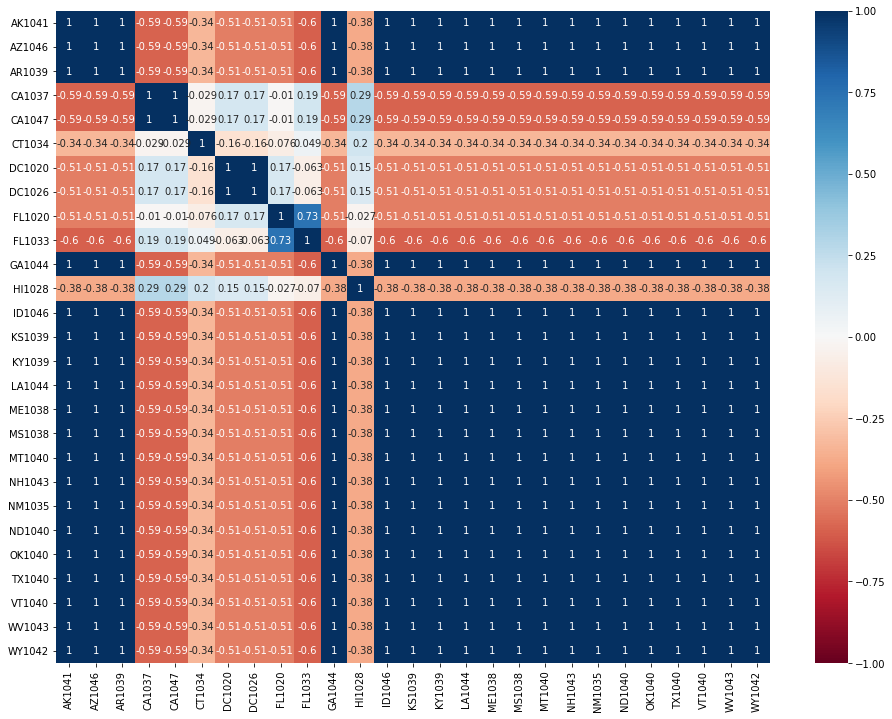

In [57]:
#Cosine similarity of groups of laws

#Step 0: Choose a group to compare
law_group = law_df_rest[law_df_rest['Law Class']=='waiting period']

#Step 1: Take content column and convert to a list
lg_list = law_group['Content_cleaned'].tolist()
#lg_list[25]

#Step 2: Create the Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer = CountVectorizer()
sparse_matrix = count_vectorizer.fit_transform(lg_list)

doc_term_matrix = sparse_matrix.todense()
df_test = pd.DataFrame(
    doc_term_matrix, 
    columns=count_vectorizer.get_feature_names()
)

#Step 3: Set up matrix
from sklearn.metrics.pairwise import cosine_similarity
array = cosine_similarity(df_test, df_test)

matrix = pd.DataFrame(array,columns=law_group['Law ID'].tolist()) 

#Step 4: Color the matrix as a correlation matrix
import seaborn as sn
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,12]

corrMatrix = matrix.corr()
sn.heatmap(corrMatrix, annot=True,cmap="RdBu",vmax=1,vmin=-1)
plt.show()

In [61]:
#Identify pairs of laws with strong negative cosine similarities
#crosswise_compare = ((np.triu(corrMatrix, 1) <= 2) * corrMatrix).stack()
crosswise_compare = corrMatrix.stack()
cc_df = pd.DataFrame(crosswise_compare).reset_index()
cc_df = cc_df.rename(
    columns={
        'level_0': 'Law1',
        'level_1': 'Law2',
        0:'CoSim'
    }
)

#Drop self-correlations
cc_df['Match'] = np.where(cc_df['Law1']==cc_df['Law2'],1,0)
cc_df.drop(cc_df[cc_df['Match'] == 1].index, inplace=True)
del cc_df['Match']

#Drop duplicates
cc_df['Combine'] = cc_df['Law1']+cc_df['Law2']
cc_df['Sorted'] = cc_df['Combine'].apply(lambda x: ''.join(sorted(x)))
cc_df.drop_duplicates(subset=['Sorted'], keep='first',inplace=True)
del cc_df['Combine'], cc_df['Sorted']


min_cosim = cc_df['CoSim'].min()

print("Dimensions of Data: ",cc_df.shape)
cc_df[cc_df['CoSim']<=min_cosim]

Dimensions of Data:  (351, 3)


,Law1,Law2,CoSim
9,AK1041,FL1033,-0.601379
36,AZ1046,FL1033,-0.601379
63,AR1039,FL1033,-0.601379
253,FL1033,GA1044,-0.601379
255,FL1033,ID1046,-0.601379
256,FL1033,KS1039,-0.601379
257,FL1033,KY1039,-0.601379
258,FL1033,LA1044,-0.601379
259,FL1033,ME1038,-0.601379
260,FL1033,MS1038,-0.601379


In [63]:
#ND1040
#LA1044

#Compare homicide/suicide rates for those laws
laws = ['ND1040','LA1044']
test = law_df[law_df['Law ID'].isin(laws)].reset_index()
# print(test['Content'][0])
# print('----------------')
# print(test['Content'][1])
test

,index,Law ID,State,ST,Law Class,Effect,Type of Change,Effective Date,Year,Content,min_age,wait_days,Suicides,Homicides,Content_cleaned,len_text,sentiment_score
0,276,LA1044,Louisiana,LA,waiting period,Restrictive,Implement,1994-02-28,1994,Beginning on the date that is 90 days after th...,NaN,5.0,9.89,16.19,beginning date days date enactment subsection ...,702,0.599353
1,471,ND1040,North Dakota,ND,waiting period,Restrictive,Implement,1994-02-28,1994,Beginning on the date that is 90 days after th...,NaN,5.0,7.52,0.49,beginning date days date enactment subsection ...,702,0.599353
